# Importation des packages

In [31]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import torch as torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import soundfile as sf
from torchsummary import summary

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1VJk20mb-W_3sYbz3u6qmiFPquP03Dizc?usp=sharing

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importation des données

Chemin du son sans le bruit.

In [33]:
path_without_noise = "drive/MyDrive/denoising_sound/with_reverb/clean_fileid_44.wav"

Utilisez la fonction `load` de librosa pour importer le son sans bruit.

In [34]:
signal, sr = librosa.load(path_without_noise)

In [35]:
signal.shape

(220500,)

Chemin du son avec le bruit.

In [36]:
path_with_noise = "drive/MyDrive/denoising_sound/with_reverb_and_noise/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav"

Utilisez la fonction `load` de librosa pour importer le son sans bruit.

In [37]:
signal_noise, sr_noise = librosa.load(path_with_noise)

In [38]:
signal_noise.shape

(220500,)

Visualisation des données

Utilisez la fonction `waveshow` de librosa pour afficher les deux signales.

Challenge : utilisez matplotlib pour afficher les graphiques cotes à cotes.

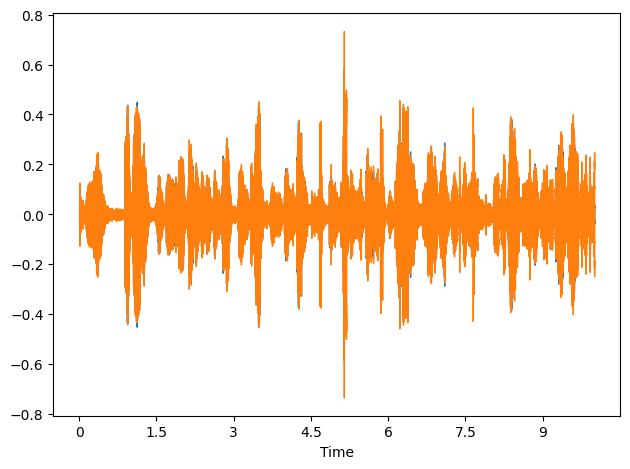

In [39]:
l = librosa.display.waveshow(signal, sr=sr)
la = librosa.display.waveshow(signal_noise, sr=sr_noise )

plt.tight_layout()
plt.show(la, l)

# Créer le générateur

La classe permettant de créer notre dataset personnalisé.

In [40]:
class CustomImageDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.img_input = x_train
        self.img_output = y_train

    def __len__(self):
        return len(self.img_output)

    def __getitem__(self, idx):
        image = self.img_input[idx, :, :]
        label = self.img_output[idx, :, :]

        return image, label

Nous allons prendre seulement les 40960 informations de la bande son.

In [41]:
x_training = CustomImageDataset(torch.from_numpy(np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1)),
                                 torch.from_numpy(np.expand_dims(np.expand_dims(signal[:40960], axis=0), axis=1)))

Utilisez la fonction `DataLoader` pour créer le générateur.

In [42]:
dataloader_train = DataLoader(x_training, batch_size=1, shuffle=True)

Vérifiez que les dimensions correspodent bien avec ce qui est attendu.

In [43]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)

  break

torch.Size([1, 1, 40960])
torch.Size([1, 1, 40960])


# Obtenir un sur-entraînement

Vous allez entraîner des modèles pour obtenir un débruitage complet du son bruité.

# fonctions d'entraînement

In [44]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss

In [53]:
import numpy as np

def fit(model, optimizer, criterion, epoch, trainloader, testloader=None):
    history_train_loss = []  # Initialize training loss history
    history_test_loss = []   # Initialize test loss history if needed

    for e in range(epoch):
        train_loss_batch = 0

        for images, labels in trainloader:
            # Update weights with the 'step' function
            model, train_loss = step(model, optimizer, criterion, images, labels)
            train_loss_batch += train_loss.detach().numpy()

        train_loss_batch /= len(trainloader.sampler)

        # Append training loss
        history_train_loss.append(train_loss_batch)

        # Calculate and append test loss if testloader is provided
        if testloader:
            test_loss_batch = 0
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                for images, labels in testloader:
                    _, test_loss = step(model, optimizer, criterion, images, labels)
                    test_loss_batch += test_loss.detach().numpy()
            test_loss_batch /= len(testloader.sampler)
            history_test_loss.append(test_loss_batch)
            model.train()  # Set model back to training mode

        # Print progress every 100 epochs
        if e % 100 == 0:
            print(f'Epoch: {e}/{epoch}')
            print('Train Loss:', np.squeeze(train_loss_batch))
            if testloader:
                print('Test Loss:', np.squeeze(test_loss_batch))
            print('-------------------------------------------------------------------------------------------------')

    # Return both history lists, with test loss optional
    return model, history_train_loss, history_test_loss if testloader else None


## Première tentative

Initialisez un modèle qui vous serivra de baseline.

Initialiser le modèle suivant:
- Utilisez la fonction `conv_block` pour initialiser une couche de convolution en 1 dimension avec 16 filtres et activer par Relu.
- Une couche de maxpooling avec une fenêtre de 2 et un stride de 2,
- Utilisez la fonction `conv_block` pour initialiser une couche de convolution en 1 dimension avec 32 filtres et activer par Relu.
- Une couche de `ConvTranspose` avec 16 filtres, une taille de filtres de 2 et un stride de 2,
- Une dernière convolution avec un filtre.

Pour ceux modèle vous allez intialisez tous vos composants dans la fonction `__init__` puis les utilisez dans le bonne ordre dans la fonction `forward`.

Vous pouvez vous nspirez de la création du modèle via ce [lien](https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201)

N'hésitez pas à demander de l'aide à ChatGPT qui permet d'aider à l'élaboration de ce type d'architecture.

In [54]:
import torch

class UNet(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Define conv_block as an internal method
        def conv_block(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),  # Use padding=1 for "same" effect
                torch.nn.ReLU(inplace=True),
            )

        # Encoder (downsampling part)
        self.encoder1 = conv_block(in_channels, 16)

        # Pooling layer
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2)

        # Bottleneck layer
        self.bottleneck = conv_block(16, 32)

        # Decoder (upsampling part)
        self.upconv2 = torch.nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)

        # Final output layer
        self.final_layer = torch.nn.Conv1d(32, out_channels, kernel_size=1)  # Update to 32 channels due to concatenation


    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        pool1 = self.pool(enc1)

        # Bottleneck
        bottleneck = self.bottleneck(pool1)

        # Decoder with skip connections
        dec2 = self.upconv2(bottleneck)
        cat2 = torch.cat((dec2, enc1), dim=1)

        # Final layer
        output = self.final_layer(cat2)

        return output


Utilisez la fonction `UNet` pour initialiser le modèle.

In [55]:
model = UNet(1,1)

Utilisez la fonction `summary` pour visualisez votre modèle.

A noter : Vous ne verrez pas apparaitre vos concatenations dans le summary c'est normal.

In [56]:
summary(model, (1, 40960))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 40960]              64
              ReLU-2            [-1, 16, 40960]               0
         MaxPool1d-3            [-1, 16, 20480]               0
            Conv1d-4            [-1, 32, 20480]           1,568
              ReLU-5            [-1, 32, 20480]               0
   ConvTranspose1d-6            [-1, 16, 40960]           1,040
            Conv1d-7             [-1, 1, 40960]              33
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.16
Forward/backward pass size (MB): 27.81
Params size (MB): 0.01
Estimated Total Size (MB): 27.98
----------------------------------------------------------------


Utilisez le modèle avec la méthode `forward`.

In [57]:
test = torch.randn(1, 1, 128)
result = model.forward(test)
result.shape

torch.Size([1, 1, 128])

Initialisez `criterion` avec la fonction `L1Loss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [58]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
epoch = 3000

Utilisez la fonction `fit` pour entraîner le modèle.

In [60]:
model, history_train_loss, history_test_loss = fit(model, optimizer, criterion, epoch, dataloader_train)

Epoch: 0/3000
Train Loss: 0.08089814335107803
-------------------------------------------------------------------------------------------------
Epoch: 100/3000
Train Loss: 0.009653883054852486
-------------------------------------------------------------------------------------------------
Epoch: 200/3000
Train Loss: 0.008609111420810223
-------------------------------------------------------------------------------------------------
Epoch: 300/3000
Train Loss: 0.008339942432940006
-------------------------------------------------------------------------------------------------
Epoch: 400/3000
Train Loss: 0.00820962991565466
-------------------------------------------------------------------------------------------------
Epoch: 500/3000
Train Loss: 0.00809820182621479
-------------------------------------------------------------------------------------------------
Epoch: 600/3000
Train Loss: 0.007950247265398502
--------------------------------------------------------------------------

Utilisez la méthode `forward` pour prédire le résultat du modèle à partir de `signal_noise_expand`

In [61]:
signal_pred = model.forward(torch.from_numpy(np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1)))

Utilisez la fonction `write` du package `soundfile` pour enregistrer `signal_noise_expand`, `signal_exapnd` et `signal_pred` avec pour nom respectif `reel_1.wav`, `pred_1.wav` et `noise_1.wav`.

In [63]:
sf.write('reel_1.wav', signal, sr)
sf.write('pred_1.wav', signal_pred.detach().numpy().squeeze(), sr) # Reshape to 1D array
sf.write('noise_1.wav', signal_noise, sr_noise)

Ecoutez le résultat afin de voir s'il est satisfaiant.

## Modèle finale

Maintenant que vous avez construit votre baseline L'objectif de ce TP est de complexifier le modèle jusqu'à ce qu'il soit capable de débruiter parfaitement le son bruité.